# ART calculations for `Yersinia Pestis` bacteria

In [44]:
import sys
import os

# Completely suppress stderr output
sys.stderr = open(os.devnull, 'w')

# Now import everything
import warnings
warnings.filterwarnings('ignore')

from pathlib import Path
sys.path.append('.')   # Add local directory to access some of the functions
sys.path.append('../../') # Make sure this is the location for the ART library

import warning_utils
warning_utils.filter_end_user_warnings()

In [45]:
import pandas as pd
import numpy as np

from art.core import RecommendationEngine
import art.utility as utils
import pickle
import cloudpickle
import matplotlib.pyplot as plt

### Define directories

In [46]:
dataDir = '/code/DTRA_ART/DrugDesignData/'
modelBuildingDataDir = os.path.join(dataDir, 'modelBuildingData/')
resultsDir = os.path.join(dataDir, 'Results/')
artResultDir = resultsDir + 'ART_results/YersiniaPestis_bestMACAW/'
os.makedirs(artResultDir, exist_ok=True)
saveDir = os.path.join(resultsDir, "Yersinia_pestis/")
#saveDir = os.path.join(resultsDir, "Yersinia_pestis_bestMACAW/")
os.makedirs(saveDir, exist_ok=True)

### Extract the data for `Yersinia Pestis` into a data frame with `duplicate` SMILES

In [32]:
YersiniaPestisData_chEMBL_wMACAW = pd.read_csv(modelBuildingDataDir + "YersiniaPestisData_chEMBL_wMACAW.csv")
YersiniaPestisData_chEMBL_wMACAW 

,ID,compound_id,Smiles,pPotency,BacteriaClassifier,MACAW_1,MACAW_2,MACAW_3,MACAW_4,MACAW_5,...,MACAW_36,MACAW_37,MACAW_38,MACAW_39,MACAW_40,MACAW_41,MACAW_42,MACAW_43,MACAW_44,MACAW_45
0,1,CHEMBL2368935,CC(=O)NCCCC(=O)N[C@@H](Cc1ccccc1)C(=O)N1Cc2ccc...,3.707744,Yersinia_pestis,-0.489942,0.215019,-0.201604,0.199008,-0.078918,...,0.037231,0.000658,-0.030241,-0.029843,0.015177,0.032328,0.011259,0.112472,-0.078607,-0.005772
1,2,CHEMBL1255638,CC(=O)NCC(=O)N[C@@H](Cc1ccccc1)C(=O)N1Cc2ccccc...,3.657577,Yersinia_pestis,-0.490464,0.215795,-0.202575,0.199030,-0.080586,...,0.036485,-0.007398,-0.018481,-0.014144,0.008878,0.000122,0.038803,0.039538,0.007608,-0.239559
2,3,CHEMBL1255640,CC(=O)N[C@@H](CCCCN)C(=O)N[C@@H](CCCCN)C(=O)N[...,4.882729,Yersinia_pestis,-0.490329,0.216233,-0.202777,0.198876,-0.079429,...,0.031153,-0.006537,-0.014612,-0.006736,0.014558,-0.003614,0.034376,0.055223,-0.039560,-0.231205
3,4,CHEMBL1255643,CC(C)C[C@H](NC(=O)[C@@H](N)CCCCN)C(=O)N1Cc2ccc...,3.823909,Yersinia_pestis,-0.490047,0.212706,-0.201936,0.201261,-0.082320,...,0.040109,-0.006957,-0.013023,-0.002984,0.019729,0.004362,0.076398,0.077211,-0.069639,-0.135709
4,5,CHEMBL1200699,C[C@H]1c2cccc(O)c2C(=O)C2=C(O)[C@]3(O)C(=O)C(C...,6.251812,Yersinia_pestis,-0.010023,-0.041827,0.092784,-0.024684,0.135607,...,0.072878,0.007147,-0.007817,0.033416,-0.030540,0.091847,0.112062,0.015061,0.053028,0.039560
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148,182,CHEMBL964,CCN(CC)C(=S)SSC(=S)N(CC)CC,4.494850,Yersinia_pestis,-0.103721,-0.356559,-0.074079,-0.053151,-0.012488,...,0.050060,0.069903,0.088649,-0.054752,0.054618,-0.109449,0.031176,-0.052170,0.073708,0.033062
149,183,CHEMBL4227290,CCCCCCCSSC(=S)N(CC)CC,4.494850,Yersinia_pestis,-0.117825,-0.486149,-0.141779,-0.157055,-0.040028,...,0.002045,0.046570,0.070894,-0.075530,0.065855,-0.110517,-0.230138,-0.190973,-0.381315,0.020509
150,184,CHEMBL1255631,CC(=O)NCCCC(=O)N[C@@H](Cc1ccccc1)C(=O)N1Cc2ccc...,4.331614,Yersinia_pestis,-0.490263,0.215098,-0.200994,0.198897,-0.080130,...,0.038573,0.001528,-0.030389,-0.027486,0.014553,0.031582,0.011023,0.108990,-0.072007,0.011341
151,186,CHEMBL1916867,CSC(=S)N/N=C/c1ccccc1O,5.397940,Yersinia_pestis,0.061029,-0.241608,0.204734,0.451870,-0.005429,...,-0.019767,-0.165761,0.005866,0.302842,0.062623,0.031800,0.224356,-0.058786,0.194650,0.130419


### Prepare data to run `ART` on `Yersinia Pestis` data with `duplicate` SMILES

#### Find Features and Response

In [33]:
input_var = [col for col in YersiniaPestisData_chEMBL_wMACAW.columns if col.startswith('MACAW_')]
print(f"MACAW Embeddings: {len(input_var)}")
print(input_var)

MACAW Embeddings: 45
['MACAW_1', 'MACAW_2', 'MACAW_3', 'MACAW_4', 'MACAW_5', 'MACAW_6', 'MACAW_7', 'MACAW_8', 'MACAW_9', 'MACAW_10', 'MACAW_11', 'MACAW_12', 'MACAW_13', 'MACAW_14', 'MACAW_15', 'MACAW_16', 'MACAW_17', 'MACAW_18', 'MACAW_19', 'MACAW_20', 'MACAW_21', 'MACAW_22', 'MACAW_23', 'MACAW_24', 'MACAW_25', 'MACAW_26', 'MACAW_27', 'MACAW_28', 'MACAW_29', 'MACAW_30', 'MACAW_31', 'MACAW_32', 'MACAW_33', 'MACAW_34', 'MACAW_35', 'MACAW_36', 'MACAW_37', 'MACAW_38', 'MACAW_39', 'MACAW_40', 'MACAW_41', 'MACAW_42', 'MACAW_43', 'MACAW_44', 'MACAW_45']


In [34]:
features = YersiniaPestisData_chEMBL_wMACAW[input_var].to_numpy()

In [35]:
response_var = ["pPotency"]
print(response_var)

['pPotency']


In [36]:
response = YersiniaPestisData_chEMBL_wMACAW[response_var].to_numpy()

### save the data as a EDD style file

In [37]:
utils.save_edd_csv(features, response, input_var, modelBuildingDataDir + 'YersiniaPestisData_chEMBL_wMACAW_ARTready.csv', response_var)

### Predict response with ART

In [38]:
YersiniaPestisData_chEMBL_wMACAW_ARTready = pd.read_csv(modelBuildingDataDir + "YersiniaPestisData_chEMBL_wMACAW_ARTready.csv")
YersiniaPestisData_chEMBL_wMACAW_ARTready

,Line Name,Type,0.0
0,0,MACAW_1,-0.489942
1,1,MACAW_1,-0.490464
2,2,MACAW_1,-0.490329
3,3,MACAW_1,-0.490047
4,4,MACAW_1,-0.010023
...,...,...,...
7033,148,pPotency,4.494850
7034,149,pPotency,4.494850
7035,150,pPotency,4.331614
7036,151,pPotency,5.397940


### Define the ART parameters needed for the prediction

In [39]:
art_params = {
    'input_vars': input_var,
    'response_vars': response_var,
    'objective': 'maximize',
    'threshold': 0.2,
    'alpha': 0.5,
    'num_recommendations': 10,
    'max_mcmc_cores': 4,
    'seed': 42,                    
    'output_dir': artResultDir,
    'recommend': False,
    'cross_val': True,
    'num_tpot_models': 2,
}

### Run ART without recommendations but with cross-validations to gauge how generalizable the results are

ART identified 153 unique designs in the training data. 
Correctly communicating your designs is critical to building ART's model and to cross-validation.  We strongly suggest verifying ART's interpretation of your designs by inspecting the preprocessed DataFrame.  For example, if your ART instance is named `engine`, run `engine.df["Design"]`.  See Data Preparation docs for a description of how ART infers design information. https://lbl-biosci.gitlab.io/ese/art/Data_Preparation/#labeling-lines-designs-replicates-oh-my
is_classifier
is_classifier
is_classifier
is_classifier
is_regressor
is_regressor
is_regressor
is_regressor
is_classifier
is_classifier
is_classifier
is_classifier
is_regressor
is_regressor
is_regressor
is_regressor
is_classifier
is_classifier
is_classifier
is_classifier
is_regressor
is_regressoris_regressor

is_regressor
is_classifier
is_classifier
is_classifier
is_classifier
is_regressor
is_regressor
is_regressor
is_classifier
is_regressor
is_classifier
is_classifier
is

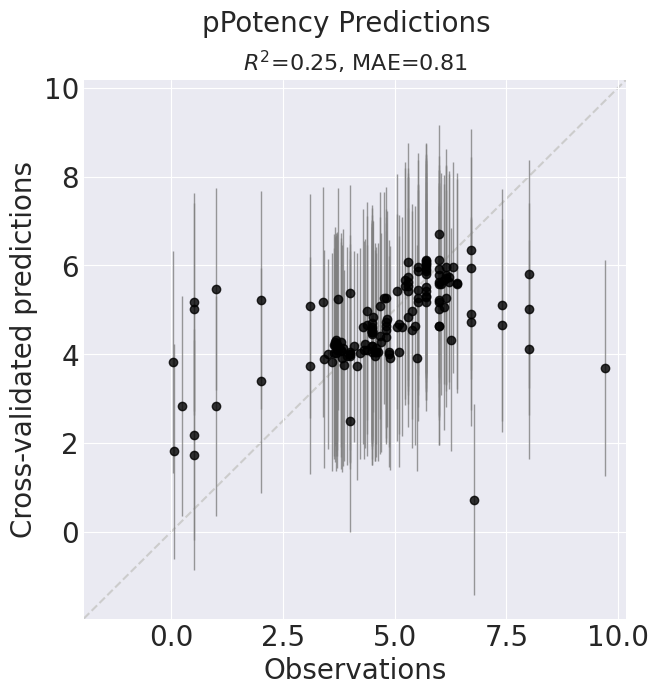

is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
i

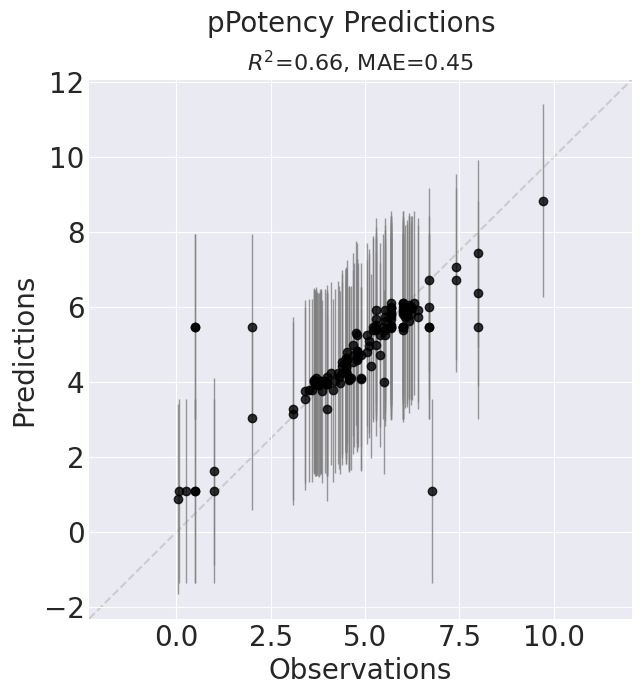

CPU times: user 12min 9s, sys: 6.32 s, total: 12min 15s
Wall time: 1h 35min 11s


In [40]:
%%time

art = RecommendationEngine(df=YersiniaPestisData_chEMBL_wMACAW_ARTready, **art_params)

In [ ]:
import shap
import matplotlib.pyplot as plt

### Find SHAP values

We will now find which input features are more important by using SHAP analysis. First, lets initialize the library:

In [ ]:
shap.initjs()

In [ ]:
plt.style.use('default')

define a wrapper function that provides the ART prediction given and input X, for use by the SHAP library

In [ ]:
def f(X):
    return art.predict(X)

convert the ART input data into the pandas dataframe that the SHAP library favors

In [ ]:
X_df = pd.DataFrame(data=art.X, columns=art_params['input_vars'])

create and execute the explainer for the features values

In [ ]:
explainer_e   = shap.Explainer(f, X_df)
shap_values_e = explainer_e(X_df)

In [ ]:
shap.summary_plot(shap_values_e)

In [ ]:
shap.plots.heatmap(shap_values_e, instance_order=shap_values_e.sum(1), max_display=15)


### Load pre-trained ART model (if necessary, otherwise skip this step)

In [ ]:
ARTtrainedModelFile = os.path.join(artResultDir, 'art.cpkl')
with open(ARTtrainedModelFile, 'rb') as f:
    art = cloudpickle.load(f)
print(f" ART model loaded from: {ARTtrainedModelFile}")

### Load MACAW transformer (not required at this moment)

## 2.1 Discovery of new hits specific to all bacteria (data source Enamine_AntiBioticData.csv)

In this section, we screen a custom virtual library looking for molecules that are promising accoring to the the SVR models `regr` above, which use 15-D MACAW embeddings as their input. The custom library ("Enamine_AntiBioticData.csv") compiled from commercial catalogs by Enamine. In particular, we are interested in molecules with high predicted pPotency.

Load MACAW embeedings for external validation data set

In [41]:
YersiniaPestis_EnamineDatasets_wMACAW = pd.read_csv(saveDir + "YersiniaPestis_EnamineDataset_wMACAW.csv")
YersiniaPestis_EnamineDatasets_wMACAW

,SMILES,MACAW_1,MACAW_2,MACAW_3,MACAW_4,MACAW_5,MACAW_6,MACAW_7,MACAW_8,MACAW_9,MACAW_10,MACAW_11,MACAW_12,MACAW_13,MACAW_14,MACAW_15
0,CC1=NN=C(COC(=O)C=2C=CC(=C(C2)[N+]([O-])=O)N3C...,-0.031818,-0.089493,0.076889,-0.018779,0.148715,-0.028113,-0.020542,-0.013082,0.087194,-0.055586,0.000364,-0.040975,0.016549,-0.069407,-0.040971
1,CC1=NC2=NC(=NN2C(C)=C1C)SCCCOC(=O)NC(N)=O,-0.046025,-0.137191,0.035613,0.011962,0.125075,-0.044643,-0.054615,-0.015864,0.094954,-0.037953,-0.023886,-0.057489,-0.020149,-0.040156,-0.024410
2,CC=1C=CC(=CC1)S(=O)(=O)NCC(=O)OCC(=O)N2CC(C)OC...,-0.036819,-0.085556,0.066172,-0.015959,0.125965,-0.015898,-0.016398,0.018044,0.074593,-0.045906,-0.024460,-0.058494,0.012732,-0.044266,-0.034370
3,CC(C)N1C=NC(=C1)S(=O)(=O)NC=2C=CN(CC=3C=CC=CN3)N2,0.012026,-0.072000,0.081442,0.029699,0.079009,-0.016692,-0.051541,0.022964,0.124392,-0.033394,-0.036944,-0.054808,0.036289,-0.037256,-0.060976
4,O=C(O)CC=1C=CC(=CC1)S(=O)(=O)NC=2C=CC(Cl)=CC2O,0.040565,-0.091303,0.060890,0.040753,0.119792,0.033381,-0.055310,0.012223,0.091722,-0.051508,0.021904,-0.079630,0.031714,-0.059753,0.032867
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31995,CCOCCCOC(=O)C1=CC(=C(C)S1)[N+]([O-])=O,-0.042424,-0.171399,0.061260,0.015440,0.127778,-0.029857,-0.024650,-0.014643,0.031052,-0.104618,-0.001936,-0.029356,0.001271,-0.015464,-0.026792
31996,CC(C)C(NS(=O)(=O)CC12CCC(CC1=O)C2(C)C)C(N)=O,-0.071068,-0.139738,0.090670,-0.007388,0.082275,0.014636,-0.042685,0.042745,0.058029,-0.102383,0.019053,-0.076399,0.006759,-0.027364,-0.023454
31997,CNC(=O)CN1CCC(CC1)NS(=O)(=O)CCCC(F)(F)F,-0.077453,-0.159441,0.034842,-0.006758,0.100846,0.003096,-0.040813,-0.032225,0.007255,-0.079202,0.030522,-0.055224,-0.026112,-0.032323,0.009832
31998,CCOC(=O)NC1CCCN(C1)C(=O)C2=CC(=NN2C3CC3)C(F)(F)F,-0.044490,-0.123271,0.021190,-0.033381,0.154406,-0.005819,-0.026642,-0.015162,0.053323,-0.054051,0.016230,-0.064335,-0.018192,-0.020493,-0.001616


In [42]:
macaw_columns = [col for col in YersiniaPestis_EnamineDatasets_wMACAW.columns if col.startswith('MACAW_')]
smi_lib_EnamineDatasets_wMACAW = YersiniaPestis_EnamineDatasets_wMACAW[macaw_columns].values

In [43]:
Y1_lib_pred = art.predict(smi_lib_EnamineDatasets_wMACAW)
Y1_lib_pred

PredictInputShapeErr: Parameter x must have shape (n_samples, len(input_vars)).Expected (n_samples, 45) but received (n_samples, 15)

Get predictions with uncertainty using ART's post_pred_stats

In [30]:
# Pass X1_lib (features)
mean, std = art.post_pred_stats(smi_lib_EnamineDatasets_wMACAW)

# Now use these for your results
EnamineAntiBioticData_predicted = YersiniaPestis_EnamineDatasets_wMACAW[['SMILES']].copy()
EnamineAntiBioticData_predicted['pPotency_prediction'] = mean
EnamineAntiBioticData_predicted['pPotency_std'] = std

# Calculate 95% Confidence Intervals
EnamineAntiBioticData_predicted['pPotency_lower_95CI'] = mean - 1.96 * std
EnamineAntiBioticData_predicted['pPotency_upper_95CI'] = mean + 1.96 * std

# Convert to IC50
EnamineAntiBioticData_predicted['IC50(M)_prediction'] = 10 ** (-mean)
EnamineAntiBioticData_predicted['IC50(M)_lower_95CI'] = 10 ** (-EnamineAntiBioticData_predicted['pPotency_upper_95CI'])
EnamineAntiBioticData_predicted['IC50(M)_upper_95CI'] = 10 ** (-EnamineAntiBioticData_predicted['pPotency_lower_95CI'])

# Select and save results
EnamineAntiBioticData_predicted = EnamineAntiBioticData_predicted.filter(
    items=["SMILES", "pPotency_prediction", "pPotency_std", 
           "pPotency_lower_95CI", "pPotency_upper_95CI",
           "IC50(M)_prediction", "IC50(M)_lower_95CI", "IC50(M)_upper_95CI"]
)

EnamineAntiBioticData_predicted.to_csv(os.path.join(saveDir + "YersiniaPestis_wART_EnamineDataset_predicted_all.csv"), index=False)
EnamineAntiBioticData_predicted[['SMILES']].to_csv(os.path.join(saveDir + "YersiniaPestis_wART_EnamineDataset_predicted_all_SMILES.csv"), index=False)
print(f"Predictions saved with uncertainty estimates")
EnamineAntiBioticData_predicted

Predictions saved with uncertainty estimates


,SMILES,pPotency_prediction,pPotency_std,pPotency_lower_95CI,pPotency_upper_95CI,IC50(M)_prediction,IC50(M)_lower_95CI,IC50(M)_upper_95CI
0,CC1=NN=C(COC(=O)C=2C=CC(=C(C2)[N+]([O-])=O)N3C...,3.929035,1.353167,1.276828,6.581241,0.000118,2.622761e-07,0.052865
1,CC1=NC2=NC(=NN2C(C)=C1C)SCCCOC(=O)NC(N)=O,4.029068,1.350470,1.382147,6.675989,0.000094,2.108680e-07,0.041481
2,CC=1C=CC(=CC1)S(=O)(=O)NCC(=O)OCC(=O)N2CC(C)OC...,4.185364,1.345941,1.547319,6.823409,0.000065,1.501728e-07,0.028358
3,CC(C)N1C=NC(=C1)S(=O)(=O)NC=2C=CN(CC=3C=CC=CN3)N2,4.411424,1.345585,1.774078,7.048771,0.000039,8.937770e-08,0.016824
4,O=C(O)CC=1C=CC(=CC1)S(=O)(=O)NC=2C=CC(Cl)=CC2O,4.279189,1.346126,1.640783,6.917595,0.000053,1.208939e-07,0.022867
...,...,...,...,...,...,...,...,...
31995,CCOCCCOC(=O)C1=CC(=C(C)S1)[N+]([O-])=O,3.924646,1.353269,1.272239,6.577052,0.000119,2.648182e-07,0.053427
31996,CC(C)C(NS(=O)(=O)CC12CCC(CC1=O)C2(C)C)C(N)=O,4.070551,1.358907,1.407093,6.734010,0.000085,1.844974e-07,0.039166
31997,CNC(=O)CN1CCC(CC1)NS(=O)(=O)CCCC(F)(F)F,3.959292,1.360654,1.292411,6.626174,0.000110,2.364975e-07,0.051002
31998,CCOC(=O)NC1CCCN(C1)C(=O)C2=CC(=NN2C3CC3)C(F)(F)F,4.030642,1.346060,1.392364,6.668919,0.000093,2.143290e-07,0.040517


## 2.2 Discovery of new hits specific to all bacteria (data source Life chemicals data set)

In this section, we screen a custom virtual library looking for molecules that are promising accoring to the the SVR models `regr` above, which use 15-D MACAW embeddings as their input. The custom library ("Enamine_AntiBioticData.csv") compiled from commercial catalogs by Enamine. In particular, we are interested in molecules with high predicted pPotency.

In [32]:
YersiniaPestis_LCAntiBioticData_wMACAW = pd.read_csv(saveDir + "YersiniaPestis_LCAntiviralsData_wMACAW.csv")
YersiniaPestis_LCAntiBioticData_wMACAW

,SMILES,MACAW_1,MACAW_2,MACAW_3,MACAW_4,MACAW_5,MACAW_6,MACAW_7,MACAW_8,MACAW_9,MACAW_10,MACAW_11,MACAW_12,MACAW_13,MACAW_14,MACAW_15
0,COC1CCCN(c2cc(N(C)C)ncn2)C1,-0.015253,-0.174457,0.041204,-0.011826,0.073990,0.001891,-0.033001,-0.007103,0.034287,-0.023194,0.009153,-0.036951,-0.010828,-0.042744,-0.012108
1,OC1CCCN(c2ncnc3c2CCCC3)C1,-0.006068,-0.181866,0.022487,0.008506,0.099656,0.077099,-0.057288,-0.038031,-0.002660,-0.057989,0.004075,-0.055028,-0.040468,0.003141,0.065497
2,CC(C)N1CCN(c2ncc(F)cn2)CC1,-0.019161,-0.168825,0.030719,0.034479,0.079483,0.033426,-0.031724,0.038391,0.030102,-0.000107,-0.007046,-0.053402,-0.027442,-0.034040,-0.005081
3,CC1CN(c2cc(N(C)C)ncn2)CC(C)O1,-0.019381,-0.147612,0.080591,0.025872,0.065461,0.007806,-0.022325,0.046037,0.061679,-0.025664,0.010061,-0.037464,-0.012188,-0.033653,-0.024465
4,CN(C)c1cc(N2CCCC(O)C2)ncn1,-0.005624,-0.176104,0.033949,0.000139,0.083130,0.043787,-0.047081,-0.016348,0.009652,-0.036122,0.017673,-0.054373,-0.015726,-0.043425,0.011055
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15532,O=C1c2cccc3cccc(c23)C(=O)N1CCCN(C(=O)c1ccc(-c2...,-0.029188,-0.019349,-0.007022,-0.017284,0.158724,-0.029053,-0.033181,0.015251,0.100458,0.016279,-0.046358,-0.084806,-0.003988,-0.064811,-0.010402
15533,O=C1Nc2ccc(S(=O)(=O)Nc3ccc(NS(=O)(=O)c4ccc5c6c...,-0.056480,-0.022501,0.029026,0.018710,0.120032,-0.020410,-0.069532,0.026297,0.168184,-0.018790,-0.050733,-0.050862,0.006093,-0.095829,0.011224
15534,Cc1ncc(CO)c2cc(C(=O)Nc3cccc4ccccc34)/c(=N/c3cc...,0.083324,0.011009,0.010739,-0.021296,0.063155,-0.112561,-0.090253,-0.006804,0.198547,-0.023507,-0.035951,-0.021470,0.038420,-0.058267,-0.022738
15535,CCOC(=O)c1sc(NC(=O)c2ccc(Oc3ccc(C(=O)Nc4nc(-c5...,-0.153701,0.032392,0.004409,0.017132,0.084837,-0.040981,-0.049921,0.004793,0.121834,0.006389,-0.054286,-0.037127,0.013913,-0.059288,-0.018997


In [33]:
macaw_columns = [col for col in YersiniaPestis_LCAntiBioticData_wMACAW.columns if col.startswith('MACAW_')]
smi_lib_LCAntiBioticData_wMACAW = YersiniaPestis_LCAntiBioticData_wMACAW[macaw_columns].values

In [34]:
Y1_lib_pred = art.predict(smi_lib_LCAntiBioticData_wMACAW)
Y1_lib_pred

array([[4.26026101],
       [4.16447482],
       [4.20047766],
       ...,
       [4.67572826],
       [4.02122548],
       [4.1889851 ]])

Get predictions with uncertainty using ART's post_pred_stats

In [35]:
# Pass X1_lib (features)
mean, std = art.post_pred_stats(smi_lib_LCAntiBioticData_wMACAW)

# Now use these for your results
LCAntiBioticData_predicted = YersiniaPestis_LCAntiBioticData_wMACAW[['SMILES']].copy()
LCAntiBioticData_predicted['pPotency_prediction'] = mean
LCAntiBioticData_predicted['pPotency_std'] = std

# Calculate 95% Confidence Intervals
LCAntiBioticData_predicted['pPotency_lower_95CI'] = mean - 1.96 * std
LCAntiBioticData_predicted['pPotency_upper_95CI'] = mean + 1.96 * std

# Convert to IC50
LCAntiBioticData_predicted['IC50(M)_prediction'] = 10 ** (-mean)
LCAntiBioticData_predicted['IC50(M)_lower_95CI'] = 10 ** (-LCAntiBioticData_predicted['pPotency_upper_95CI'])
LCAntiBioticData_predicted['IC50(M)_upper_95CI'] = 10 ** (-LCAntiBioticData_predicted['pPotency_lower_95CI'])

# Select and save results
LCAntiBioticData_predicted = LCAntiBioticData_predicted.filter(
    items=["SMILES", "pPotency_prediction", "pPotency_std", 
           "pPotency_lower_95CI", "pPotency_upper_95CI",
           "IC50(M)_prediction", "IC50(M)_lower_95CI", "IC50(M)_upper_95CI"]
)

LCAntiBioticData_predicted.to_csv(os.path.join(saveDir + "YersiniaPestis_wART_LCAntiBioticData_predicted_all.csv"), index=False)
LCAntiBioticData_predicted[['SMILES']].to_csv(os.path.join(saveDir + "YersiniaPestis_wART_LCAntiBioticData_predicted_all_SMILES.csv"), index=False)
print(f"Predictions saved with uncertainty estimates")
LCAntiBioticData_predicted

Predictions saved with uncertainty estimates


,SMILES,pPotency_prediction,pPotency_std,pPotency_lower_95CI,pPotency_upper_95CI,IC50(M)_prediction,IC50(M)_lower_95CI,IC50(M)_upper_95CI
0,COC1CCCN(c2cc(N(C)C)ncn2)C1,4.260261,1.355010,1.604442,6.916080,0.000055,1.213165e-07,0.024863
1,OC1CCCN(c2ncnc3c2CCCC3)C1,4.164475,1.355525,1.507646,6.821304,0.000068,1.509024e-07,0.031071
2,CC(C)N1CCN(c2ncc(F)cn2)CC1,4.200478,1.353534,1.547550,6.853405,0.000063,1.401507e-07,0.028343
3,CC1CN(c2cc(N(C)C)ncn2)CC(C)O1,4.185364,1.357250,1.525154,6.845574,0.000065,1.427005e-07,0.029843
4,CN(C)c1cc(N2CCCC(O)C2)ncn1,4.223285,1.356147,1.565236,6.881333,0.000060,1.314218e-07,0.027212
...,...,...,...,...,...,...,...,...
15532,O=C1c2cccc3cccc(c23)C(=O)N1CCCN(C(=O)c1ccc(-c2...,4.122889,1.343156,1.490303,6.755475,0.000075,1.756000e-07,0.032337
15533,O=C1Nc2ccc(S(=O)(=O)Nc3ccc(NS(=O)(=O)c4ccc5c6c...,3.992393,1.359755,1.327273,6.657513,0.000102,2.200328e-07,0.047068
15534,Cc1ncc(CO)c2cc(C(=O)Nc3cccc4ccccc34)/c(=N/c3cc...,4.675728,1.346814,2.035973,7.315484,0.000021,4.836335e-08,0.009205
15535,CCOC(=O)c1sc(NC(=O)c2ccc(Oc3ccc(C(=O)Nc4nc(-c5...,4.021225,1.350169,1.374894,6.667557,0.000095,2.150025e-07,0.042180


## 2.3 Discovery of new hits specific to all viruses (data source `chemDiv` data set)

In this section, we screen a custom virtual library looking for molecules that are promising accoring to the the SVR models `regr` above, which use 15-D MACAW embeddings as their input. The custom library compiled from commercial catalogs by Enamine. In particular, we are interested in molecules with high predicted pPotency.

In [36]:
YersiniaPestis_ChemDivAntiBioticData_wMACAW = pd.read_csv(saveDir + "YersiniaPestis_ChemDivAntiviralsData_wMACAW.csv")
YersiniaPestis_ChemDivAntiBioticData_wMACAW

,SMILES,MACAW_1,MACAW_2,MACAW_3,MACAW_4,MACAW_5,MACAW_6,MACAW_7,MACAW_8,MACAW_9,MACAW_10,MACAW_11,MACAW_12,MACAW_13,MACAW_14,MACAW_15
0,O=C(Oc1ccc(-c2ccccc2)cc1)c1ccc([N+](=O)[O-])cc1,0.050497,-0.076697,0.055395,0.031207,0.096158,0.039348,-0.045717,0.034950,0.092484,-0.010617,-0.040538,-0.039878,0.034593,-0.029349,-0.039583
1,COc1ccc(/C=N/NC(=O)c2ccn(C)n2)cc1,0.064831,-0.099955,0.085714,0.110473,0.053698,-0.040851,-0.048611,0.018557,0.130765,-0.022477,0.010730,-0.004690,0.088875,-0.075832,-0.022982
2,CC1(C)OC1COc1cc(=O)oc2cc3occc3cc12,-0.010055,-0.118128,0.098655,0.041362,0.117972,-0.025555,-0.041486,0.084871,0.086959,-0.086092,-0.006986,-0.033375,0.068735,-0.064701,-0.042925
3,O=C(Cc1ccccc1)c1ccc(-c2ccccc2)cc1,0.074967,-0.083308,0.042214,0.065220,0.082924,0.064679,-0.090621,0.080175,0.119650,-0.001434,-0.076688,-0.064511,0.053187,0.000290,-0.024760
4,O=C(Nc1ccc(Oc2ccccc2)cc1)c1cccc(C(=O)Nc2ccc(Oc...,-0.006854,-0.019523,0.035207,0.003580,0.080171,-0.036557,-0.054821,0.036385,0.156915,-0.011349,-0.063200,-0.034303,0.020031,-0.037184,-0.020469
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12505,Nc1nc(Nc2ccccc2F)nc2ccccc12,0.098809,-0.092302,0.073829,0.134095,0.064368,0.098179,-0.077597,0.010541,0.137891,0.032539,-0.001247,0.005317,0.044900,0.000895,-0.018067
12506,CNc1nc(Nc2ccccc2F)nc2ccccc12,0.101418,-0.086995,0.066275,0.128146,0.061150,0.034666,-0.071848,0.049047,0.132059,-0.005532,-0.061571,0.022721,0.018738,-0.026767,-0.005114
12507,Nc1nc(Nc2ccccc2Cl)nc2ccccc12,0.088236,-0.089896,0.089736,0.128619,0.061415,0.083115,-0.113226,0.009254,0.157908,0.021343,0.003492,0.024605,0.045386,0.006222,-0.038373
12508,CNc1nc(Nc2ccccc2Cl)nc2ccccc12,0.095617,-0.082416,0.078025,0.118922,0.054662,0.019704,-0.101688,0.049023,0.151217,-0.014790,-0.052874,0.044040,0.022676,-0.024983,-0.024871


In [37]:
macaw_columns = [col for col in YersiniaPestis_ChemDivAntiBioticData_wMACAW.columns if col.startswith('MACAW_')]
smi_lib_ChemDivAntiBioticData_wMACAW = YersiniaPestis_ChemDivAntiBioticData_wMACAW[macaw_columns].values

In [38]:
Y1_lib_pred = art.predict(smi_lib_ChemDivAntiBioticData_wMACAW)
Y1_lib_pred

array([[4.42134706],
       [4.31670515],
       [4.11252298],
       ...,
       [4.40740822],
       [4.53757747],
       [4.45506612]])

Get predictions with uncertainty using ART's post_pred_stats

In [39]:
# Pass X1_lib (features)
mean, std = art.post_pred_stats(smi_lib_ChemDivAntiBioticData_wMACAW)

# Now use these for your results
ChemDivAntiBioticData_predicted = YersiniaPestis_ChemDivAntiBioticData_wMACAW[['SMILES']].copy()
ChemDivAntiBioticData_predicted['pPotency_prediction'] = mean
ChemDivAntiBioticData_predicted['pPotency_std'] = std

# Calculate 95% Confidence Intervals
ChemDivAntiBioticData_predicted['pPotency_lower_95CI'] = mean - 1.96 * std
ChemDivAntiBioticData_predicted['pPotency_upper_95CI'] = mean + 1.96 * std

# Convert to IC50
ChemDivAntiBioticData_predicted['IC50(M)_prediction'] = 10 ** (-mean)
ChemDivAntiBioticData_predicted['IC50(M)_lower_95CI'] = 10 ** (-ChemDivAntiBioticData_predicted['pPotency_upper_95CI'])
ChemDivAntiBioticData_predicted['IC50(M)_upper_95CI'] = 10 ** (-ChemDivAntiBioticData_predicted['pPotency_lower_95CI'])

# Select and save results
ChemDivAntiBioticData_predicted = ChemDivAntiBioticData_predicted.filter(
    items=["SMILES", "pPotency_prediction", "pPotency_std", 
           "pPotency_lower_95CI", "pPotency_upper_95CI",
           "IC50(M)_prediction", "IC50(M)_lower_95CI", "IC50(M)_upper_95CI"]
)

ChemDivAntiBioticData_predicted.to_csv(os.path.join(saveDir + "YersiniaPestis_wART_ChemDivAntiBioticData_predicted_all.csv"), index=False)
ChemDivAntiBioticData_predicted[['SMILES']].to_csv(os.path.join(saveDir + "YersiniaPestis_wART_ChemDivAntiBioticData_predicted_all_SMILES.csv"), index=False)
print(f"Predictions saved with uncertainty estimates")
ChemDivAntiBioticData_predicted

Predictions saved with uncertainty estimates


,SMILES,pPotency_prediction,pPotency_std,pPotency_lower_95CI,pPotency_upper_95CI,IC50(M)_prediction,IC50(M)_lower_95CI,IC50(M)_upper_95CI
0,O=C(Oc1ccc(-c2ccccc2)cc1)c1ccc([N+](=O)[O-])cc1,4.421347,1.350228,1.774900,7.067794,0.000038,8.554718e-08,0.016792
1,COc1ccc(/C=N/NC(=O)c2ccn(C)n2)cc1,4.316705,1.353587,1.663676,6.969735,0.000048,1.072174e-07,0.021693
2,CC1(C)OC1COc1cc(=O)oc2cc3occc3cc12,4.112523,1.352354,1.461909,6.763137,0.000077,1.725293e-07,0.034522
3,O=C(Cc1ccccc1)c1ccc(-c2ccccc2)cc1,4.586986,1.348080,1.944749,7.229222,0.000026,5.898990e-08,0.011357
4,O=C(Nc1ccc(Oc2ccccc2)cc1)c1cccc(C(=O)Nc2ccc(Oc...,4.417087,1.345388,1.780128,7.054047,0.000038,8.829843e-08,0.016591
...,...,...,...,...,...,...,...,...
12505,Nc1nc(Nc2ccccc2F)nc2ccccc12,4.418007,1.352687,1.766742,7.069273,0.000038,8.525637e-08,0.017110
12506,CNc1nc(Nc2ccccc2F)nc2ccccc12,4.540257,1.347067,1.900006,7.180507,0.000029,6.599219e-08,0.012589
12507,Nc1nc(Nc2ccccc2Cl)nc2ccccc12,4.407408,1.353451,1.754645,7.060171,0.000039,8.706198e-08,0.017594
12508,CNc1nc(Nc2ccccc2Cl)nc2ccccc12,4.537577,1.348542,1.894435,7.180720,0.000029,6.595986e-08,0.012752


### 2.4 Checking drug likeliness of `Basidalin`

In [40]:
YersiniaPestis_DTRA_target_AntiBiotic_wMACAW = pd.read_csv(saveDir + "YersiniaPestis_DTRA_smiles_wMACAW.csv")
YersiniaPestis_DTRA_target_AntiBiotic_wMACAW

,SMILES,MACAW_1,MACAW_2,MACAW_3,MACAW_4,MACAW_5,MACAW_6,MACAW_7,MACAW_8,MACAW_9,MACAW_10,MACAW_11,MACAW_12,MACAW_13,MACAW_14,MACAW_15
0,C1=C(/C(=C\C=O)/OC1=O)N,-0.032778,-0.16621,0.08575,0.103495,0.093761,0.020951,-0.052445,0.035058,0.071336,-0.02435,0.023206,-0.028243,0.019394,-0.014642,-0.02053


In [41]:
macaw_columns = [col for col in YersiniaPestis_DTRA_target_AntiBiotic_wMACAW.columns if col.startswith('MACAW_')]
smi_lib_DTRA_target_AntiBiotic_wMACAW = YersiniaPestis_DTRA_target_AntiBiotic_wMACAW[macaw_columns].values

In [42]:
Y1_lib_pred = art.predict(smi_lib_DTRA_target_AntiBiotic_wMACAW)
Y1_lib_pred

array([[3.98859977]])

Get predictions with uncertainty using ART's post_pred_stats

In [43]:
# Pass X1_lib (features)
mean, std = art.post_pred_stats(smi_lib_DTRA_target_AntiBiotic_wMACAW)

# Now use these for your results
DTRA_target_AntiBiotic_predicted = YersiniaPestis_DTRA_target_AntiBiotic_wMACAW[['SMILES']].copy()
DTRA_target_AntiBiotic_predicted['pPotency_prediction'] = mean
DTRA_target_AntiBiotic_predicted['pPotency_std'] = std

# Calculate 95% Confidence Intervals
DTRA_target_AntiBiotic_predicted['pPotency_lower_95CI'] = mean - 1.96 * std
DTRA_target_AntiBiotic_predicted['pPotency_upper_95CI'] = mean + 1.96 * std

# Convert to IC50
DTRA_target_AntiBiotic_predicted['IC50(M)_prediction'] = 10 ** (-mean)
DTRA_target_AntiBiotic_predicted['IC50(M)_lower_95CI'] = 10 ** (-DTRA_target_AntiBiotic_predicted['pPotency_upper_95CI'])
DTRA_target_AntiBiotic_predicted['IC50(M)_upper_95CI'] = 10 ** (-DTRA_target_AntiBiotic_predicted['pPotency_lower_95CI'])

# Select and save results
DTRA_target_AntiBiotic_predicted = DTRA_target_AntiBiotic_predicted.filter(
    items=["SMILES", "pPotency_prediction", "pPotency_std", 
           "pPotency_lower_95CI", "pPotency_upper_95CI",
           "IC50(M)_prediction", "IC50(M)_lower_95CI", "IC50(M)_upper_95CI"]
)

DTRA_target_AntiBiotic_predicted.to_csv(os.path.join(saveDir + "YersiniaPestis_wART_DTRA_target_AntiBiotic_predicted_all.csv"), index=False)
DTRA_target_AntiBiotic_predicted[['SMILES']].to_csv(os.path.join(saveDir + "YersiniaPestis_wART_DTRA_target_AntiBiotic_predicted_all_SMILES.csv"), index=False)
print(f"Predictions saved with uncertainty estimates")
DTRA_target_AntiBiotic_predicted

Predictions saved with uncertainty estimates


,SMILES,pPotency_prediction,pPotency_std,pPotency_lower_95CI,pPotency_upper_95CI,IC50(M)_prediction,IC50(M)_lower_95CI,IC50(M)_upper_95CI
0,C1=C(/C(=C\C=O)/OC1=O)N,3.9886,1.358012,1.326896,6.650304,0.000103,2.237156e-07,0.047109


# Prepare to run `ART` on `Yersinia Pestis` data without `duplicate` SMILES

In [48]:
YersiniaPestisData_chEMBL_noDuplicates_wMACAW = pd.read_csv(modelBuildingDataDir + "YersiniaPestisData_chEMBL_noDuplicates_wMACAW.csv")
YersiniaPestisData_chEMBL_noDuplicates_wMACAW 

,Smiles,BacteriaClassifier,pPotency,MACAW_1,MACAW_2,MACAW_3,MACAW_4,MACAW_5,MACAW_6,MACAW_7,MACAW_8,MACAW_9,MACAW_10,MACAW_11,MACAW_12,MACAW_13,MACAW_14,MACAW_15
0,CC(=O)NCC(=O)N[C@@H](Cc1ccc(F)cc1)C(=O)N1Cc2cc...,Yersinia_pestis,3.694649,-0.493957,0.085737,-0.015786,-0.100486,0.059587,-0.007523,0.013764,-0.106147,0.080116,-0.057045,-0.047472,0.017277,-0.031311,0.060098,-0.091242
1,CC(=O)NCC(=O)N[C@@H](Cc1ccccc1)C(=O)N1CCc2cccc...,Yersinia_pestis,3.688246,-0.494332,0.085638,-0.016685,-0.099251,0.059743,-0.007965,0.011084,-0.101626,0.075294,-0.053289,-0.046974,0.013838,-0.031601,0.056937,-0.089366
2,CC(=O)NCC(=O)N[C@@H](Cc1ccccc1)C(=O)N1CCc2cccc...,Yersinia_pestis,4.568636,-0.493362,0.086039,-0.017108,-0.097669,0.058397,-0.007928,0.010468,-0.098706,0.073122,-0.051813,-0.045923,0.012579,-0.031357,0.054613,-0.085865
3,CC(=O)NCC(=O)N[C@@H](Cc1ccccc1)C(=O)N1C[C@@H](...,Yersinia_pestis,3.684030,-0.491134,0.083606,-0.019073,-0.092205,0.058471,-0.006978,0.010381,-0.095524,0.073273,-0.051545,-0.046989,0.012366,-0.033557,0.049103,-0.082254
4,CC(=O)NCC(=O)N[C@@H](Cc1ccccc1)C(=O)N1Cc2ccccc...,Yersinia_pestis,3.688246,-0.495358,0.085630,-0.016136,-0.099768,0.059988,-0.008220,0.013577,-0.106797,0.079735,-0.056634,-0.047094,0.016000,-0.030768,0.061052,-0.092422
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87,Oc1ccccc1C1=NN(C(=S)Nc2ccccc2)[C@H](c2cccs2)C1,Yersinia_pestis,8.000000,0.340573,0.108673,0.080293,-0.087775,-0.002404,-0.051404,-0.033683,-0.058575,0.026027,0.030218,0.017700,-0.129694,0.066251,0.102575,0.051325
88,Oc1ccccc1C1=NN[C@H](c2ccccc2O)C1,Yersinia_pestis,4.777198,0.276147,-0.039625,-0.253456,-0.244141,0.074390,-0.077841,-0.058477,0.107866,-0.036449,-0.001544,0.012621,0.006344,-0.006195,-0.049290,0.010111
89,c1cc2cc(-c3ccc(-c4cc5ccc(C6=NCCN6)cc5[nH]4)cc3...,Yersinia_pestis,3.400000,0.107759,-0.072737,-0.191776,0.304881,0.216232,-0.176833,-0.216905,-0.036557,-0.120357,0.054288,0.160540,-0.032228,0.020346,-0.041493,-0.026047
90,c1cc2cc(-c3ccc4cc(-c5ccc6oc(C7=NCCN7)cc6c5)[nH...,Yersinia_pestis,9.700000,0.084829,-0.061888,-0.180858,0.341164,0.223460,-0.151307,-0.238242,-0.039200,-0.112387,0.050372,0.177045,-0.076017,-0.001786,-0.047796,0.031113


### Prepare data to run `ART` on `Yersinia Pestis` data with `duplicate` SMILES

#### Find Features and Response

In [49]:
input_var = [col for col in YersiniaPestisData_chEMBL_noDuplicates_wMACAW.columns if col.startswith('MACAW_')]
print(f"MACAW Embeddings: {len(input_var)}")
print(input_var)

MACAW Embeddings: 15
['MACAW_1', 'MACAW_2', 'MACAW_3', 'MACAW_4', 'MACAW_5', 'MACAW_6', 'MACAW_7', 'MACAW_8', 'MACAW_9', 'MACAW_10', 'MACAW_11', 'MACAW_12', 'MACAW_13', 'MACAW_14', 'MACAW_15']


In [50]:
features = YersiniaPestisData_chEMBL_noDuplicates_wMACAW[input_var].to_numpy()

In [51]:
response_var = ["pPotency"]
print(response_var)

['pPotency']


In [52]:
response = YersiniaPestisData_chEMBL_noDuplicates_wMACAW[response_var].to_numpy()

### save the data as a EDD style file

In [53]:
utils.save_edd_csv(features, response, input_var, modelBuildingDataDir + 'YersiniaPestisData_chEMBL_noDuplicates_wMACAW_ARTready.csv', response_var)

### Predict response with ART

In [54]:
YersiniaPestisData_chEMBL_noDuplicates_wMACAW_ARTready = pd.read_csv(modelBuildingDataDir + "YersiniaPestisData_chEMBL_noDuplicates_wMACAW_ARTready.csv")
YersiniaPestisData_chEMBL_noDuplicates_wMACAW_ARTready

,Line Name,Type,0.0
0,0,MACAW_1,-0.493957
1,1,MACAW_1,-0.494332
2,2,MACAW_1,-0.493362
3,3,MACAW_1,-0.491134
4,4,MACAW_1,-0.495358
...,...,...,...
1467,87,pPotency,8.000000
1468,88,pPotency,4.777198
1469,89,pPotency,3.400000
1470,90,pPotency,9.700000


### Define the ART parameters needed for the prediction

In [55]:
art_params = {
    'input_vars': input_var,
    'response_vars': response_var,
    'objective': 'maximize',
    'threshold': 0.2,
    'alpha': 0.5,
    'num_recommendations': 10,
    'max_mcmc_cores': 4,
    'seed': 42,                    
    'output_dir': artResultDir,
    'recommend': False,
    'cross_val': True,
    'num_tpot_models': 2,
}

### Run ART without recommendations but with cross-validations to gauge how generalizable the results are

In [ ]:
%%time

art = RecommendationEngine(df=YersiniaPestisData_chEMBL_noDuplicates_wMACAW_ARTready, **art_params)